In [2]:
!pip install split-folders

In [3]:
from keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense
import matplotlib.pyplot as plt

import numpy as np
from skimage import transform
import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

import splitfolders

In [4]:
splitfolders.ratio(
    "../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=7,
   ratio=(0.90,0.050, 0.050)
)

Copying files: 12446 files [00:09, 1270.77 files/s]


In [5]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory('./dataset/train',
                                                  target_size=(200, 200),
                                                  color_mode='grayscale',
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  )

test_dataset = test_datagen.flow_from_directory('./dataset/test',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory('./dataset/val',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )


Found 11200 images belonging to 4 classes.
Found 626 images belonging to 4 classes.
Found 620 images belonging to 4 classes.


In [6]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=train_dataset.image_shape))
model.add(MaxPool2D(2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))


model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 64)        0

In [7]:
import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [8]:
Info = model.fit(
                 train_dataset,
                 validation_data=valid_dataset,
                 epochs=5,
                 )

Epoch 1/5
112/112 [==============================] - 69s 486ms/step - loss: 1.0769 - accuracy: 0.5703 - precision: 0.6748 - recall: 0.3782 - val_loss: 0.6961 - val_accuracy: 0.7323 - val_precision: 0.7958 - val_recall: 0.6726
Epoch 2/5
112/112 [==============================] - 47s 423ms/step - loss: 0.5466 - accuracy: 0.7846 - precision: 0.8260 - recall: 0.7390 - val_loss: 0.2615 - val_accuracy: 0.9048 - val_precision: 0.9101 - val_recall: 0.8984
Epoch 3/5
112/112 [==============================] - 48s 427ms/step - loss: 0.1899 - accuracy: 0.9420 - precision: 0.9472 - recall: 0.9347 - val_loss: 0.5425 - val_accuracy: 0.8145 - val_precision: 0.8322 - val_recall: 0.8000
Epoch 4/5
112/112 [==============================] - 45s 403ms/step - loss: 0.1037 - accuracy: 0.9678 - precision: 0.9701 - recall: 0.9661 - val_loss: 0.0293 - val_accuracy: 0.9935 - val_precision: 0.9935 - val_recall: 0.9935
Epoch 5/5
112/112 [==============================] - 47s 415ms/step - loss: 0.0747 - accuracy: 0

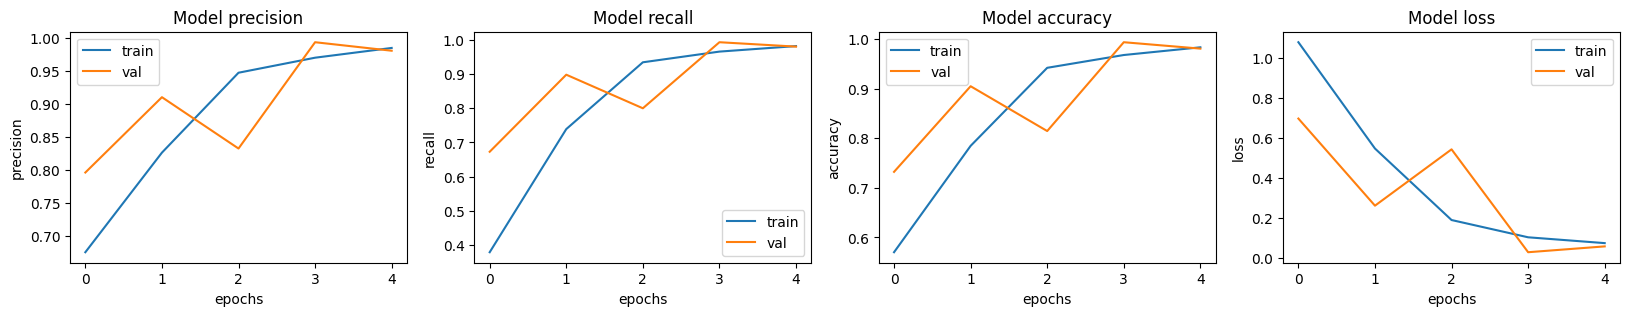

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(Info.history[met])
    ax[i].plot(Info.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [10]:
predictions = model.predict(test_dataset)

7/7 [==============================] - 3s 373ms/step


In [11]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [12]:
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(20,20))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.9776357827476039
Precision: 0.9825
Recall: 0.95
F1_score: 0.9631548647092688


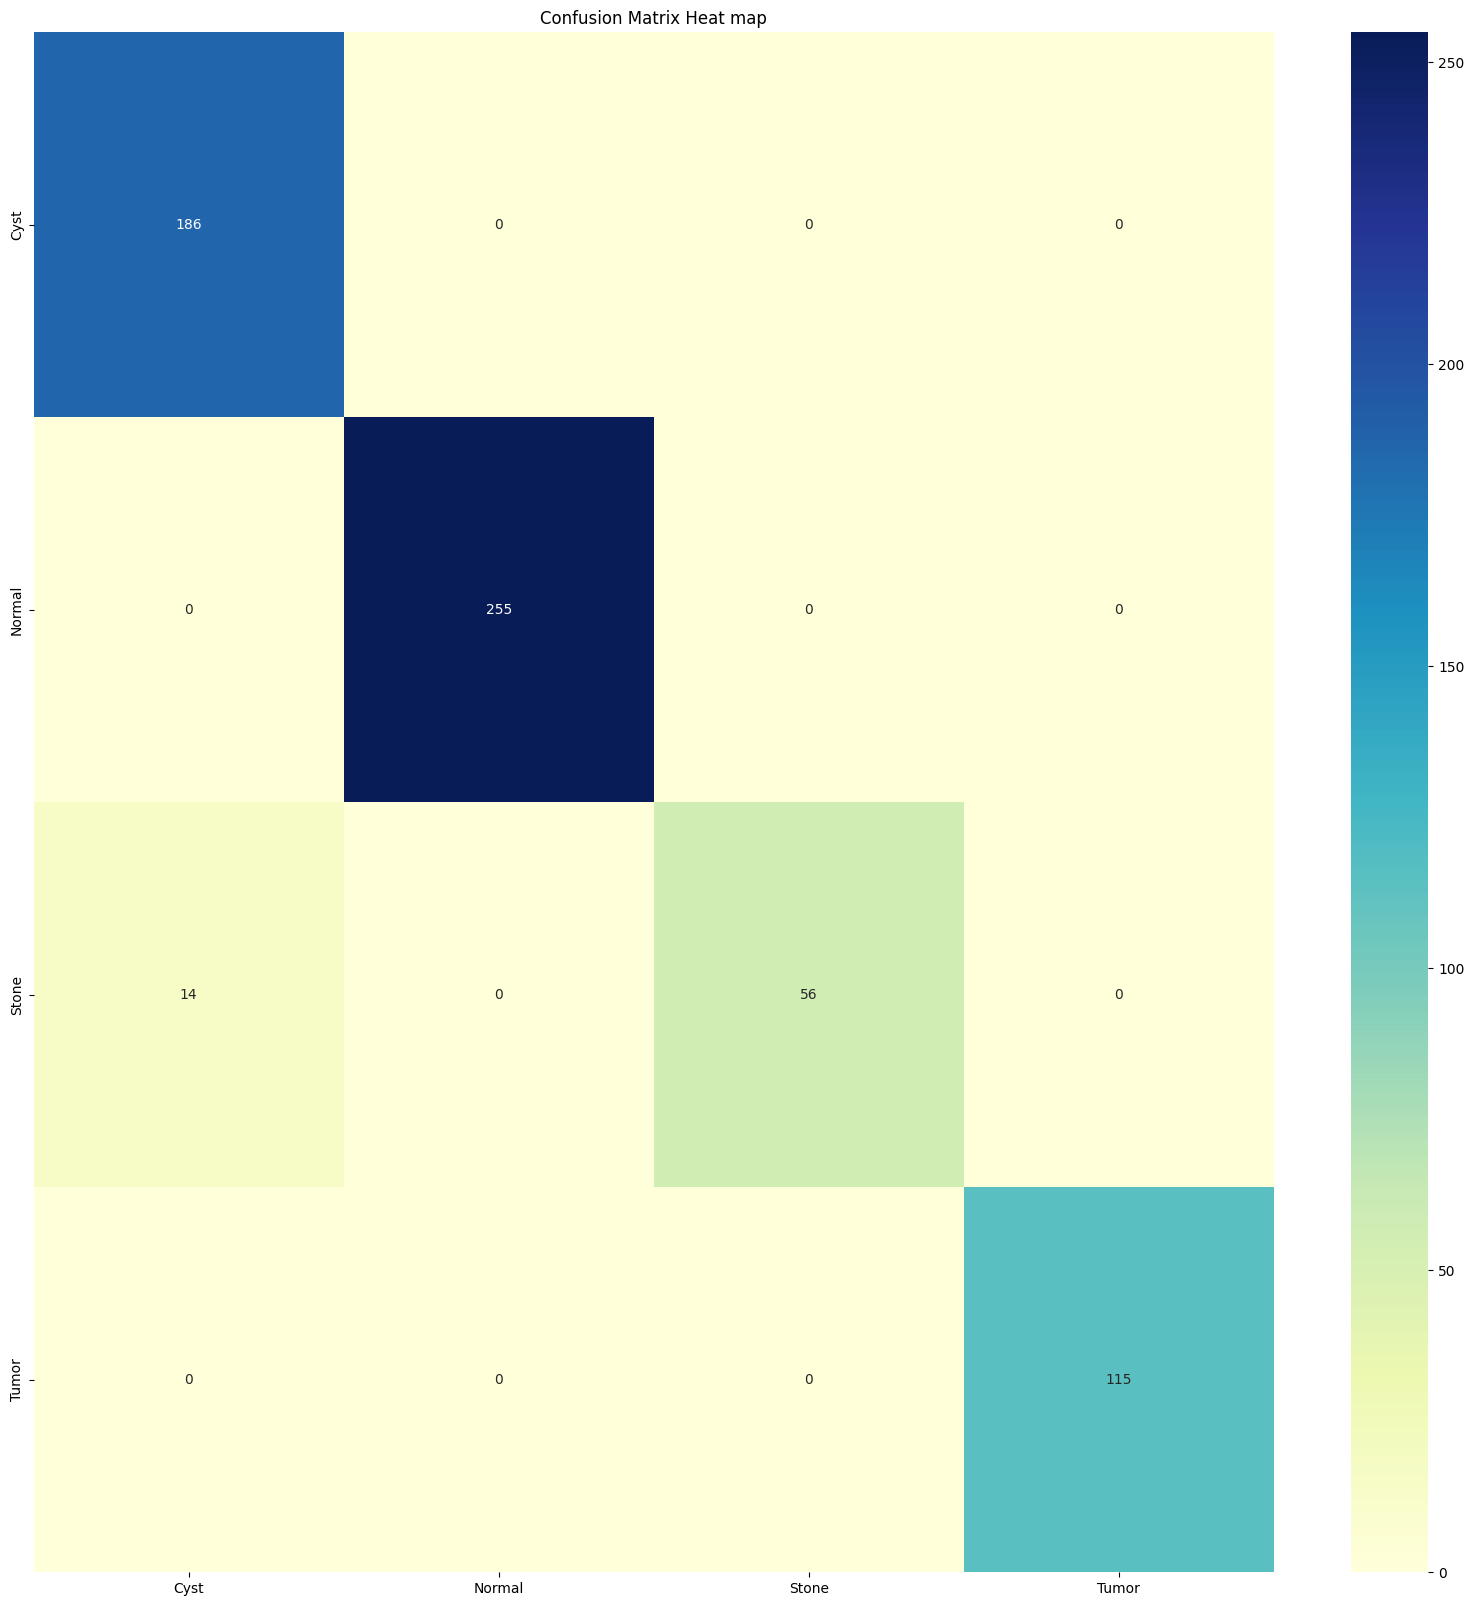

In [13]:
evaluate(test_dataset.classes,predictions)

In [14]:
model.evaluate(test_dataset)

7/7 [==============================] - 3s 446ms/step - loss: 0.1161 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776


[0.1161431297659874,
 0.9776358008384705,
 0.9776358008384705,
 0.9776358008384705]

In [15]:
model.save("Kidney_Stone.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
